In [1]:
# %pip install -U lightgbm==3.3.2

In [2]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

import pickle
from tqdm import tqdm
import gc
from pathlib import Path

In [3]:
import warnings
import sys
from IPython.core.interactiveshell import InteractiveShell

warnings.filterwarnings("ignore")
sys.path.append("../src/") # path to the `src`` folder
InteractiveShell.ast_node_interactivity = "all"
tqdm.pandas()

In [4]:
from data import DataHelper
from data.metrics import map_at_k, hr_at_k, recall_at_k

from retrieval.rules import (
    OrderHistory,
    OrderHistoryDecay,
    ItemPair,

    UserGroupTimeHistory,
    UserGroupSaleTrend,

    TimeHistory,
    TimeHistoryDecay,
    SaleTrend,

    OutOfStock,
)
from retrieval.collector import RuleCollector

from features import cum_sale, week_sale, repurchase_ratio, purchased_before

from utils import calc_valid_date, merge_week_data


In [5]:
data_dir = Path("../src/data/")

In [6]:
TRAIN_WEEK_NUM = 6
WEEK_NUM = TRAIN_WEEK_NUM + 2
VERSION_NAME = "pivot"# "v1"

In [7]:
import os
if not os.path.exists(data_dir/"interim"/VERSION_NAME):
    os.mkdir(data_dir/"interim"/VERSION_NAME)

In [8]:
TEST = True # * Set as `False` when do local experiments to save time

Pepare data: encoding ids and preprocessing

In [9]:
dh = DataHelper(data_dir)

In [10]:
data = dh.preprocess_data(save=True, name="encoded_full") # * run only once, processed data will be saved

Encode Item Sparse Feats: 100%|██████████| 12/12 [00:01<00:00,  8.31it/s]


In [11]:
data = dh.load_data(name="encoded_full")

In [12]:
uid2idx = pickle.load(open(data_dir/"index_id_map/user_id2index.pkl", "rb"))
submission = pd.read_csv(data_dir/"raw"/'sample_submission.csv')
submission['customer_id'] = submission['customer_id'].map(uid2idx)

## Retrieval


Generate candidates for each week

In [13]:
listBin = [-1, 19, 29, 39, 49, 59, 69, 119]
data['user']['age_bins'] = pd.cut(data['user']['age'], listBin)

In [14]:
# * WEEK_NUM = 0: test
# * WEEK_NUM = 1: valid
# * WEEK_NUM > 1: train

for week in range(1, WEEK_NUM):
    # * use sliding window to generate candidates
    if week == 0 and not TEST:
        continue
    trans = data["inter"]

    start_date, end_date = calc_valid_date(week)
    print(f"Week {week}: [{start_date}, {end_date})")
    
    last_week_start = pd.to_datetime(start_date) - pd.Timedelta(days=7)
    last_week_start = last_week_start.strftime("%Y-%m-%d")
    
    last_3day_start = pd.to_datetime(start_date) - pd.Timedelta(days=3)
    last_3day_start = last_3day_start.strftime("%Y-%m-%d")

    train, valid = dh.split_data(trans, start_date, end_date)

    last_week = train.loc[train.t_dat >= last_week_start]
    last_week = last_week.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')
    
    last_3days = train.loc[train.t_dat >= last_3day_start]
    last_3days = last_3days.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')
    
    train = train.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')

    if week != 0:
        customer_list = valid["customer_id"].values
    else:
        customer_list = submission['customer_id'].values

    # * ========================== Retrieval Strategies ==========================

    candidates = RuleCollector().collect(
        valid = valid,
        customer_list=customer_list,
        rules=[
            OrderHistory(train, 3),
            OrderHistory(train, 7),
            OrderHistoryDecay(train, 3, n=50),
            OrderHistoryDecay(train, 7, n=50),
            ItemPair(OrderHistory(train, 3).retrieve(), name='1'),
            ItemPair(OrderHistory(train, 7).retrieve(), name='2'),
            ItemPair(OrderHistoryDecay(train, 3, n=50).retrieve(), name='3'),
            ItemPair(OrderHistoryDecay(train, 7, n=50).retrieve(), name='4'),
            UserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=50, name='1'),
            UserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=50, name='2'),
            UserGroupSaleTrend(data, customer_list, train, ['age_bins'], 7, n=50),
            TimeHistory(customer_list, last_week, n=50, name='1'),
            TimeHistory(customer_list, last_3days, n=50, name='2'),
            TimeHistoryDecay(customer_list, train, 3, n=50),
            TimeHistoryDecay(customer_list, train, 7, n=50),
            SaleTrend(customer_list, train, 7, n=50),
        ],
        filters=[OutOfStock(trans)],
        min_pos_rate=0.005,
        compress=False,
    )
    
    candidates = (
        pd.pivot_table(
            candidates,
            values="score",
            index=["customer_id", "article_id"],
            columns=["method"],
            aggfunc=np.sum,
        )
        .reset_index()
        # .fillna(0)
    )

    candidates.to_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_candidate.pqt")
    if WEEK_NUM != 0:
        valid.to_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_label.pqt")

Week 1: [2020-09-16, 2020-09-23)


Retrieve items by rules:   6%|▋         | 1/16 [00:28<07:01, 28.13s/it]

Positive rate: 0.03038
Positive rate: 0.02859


Retrieve items by rules:  12%|█▎        | 2/16 [00:57<06:43, 28.82s/it]

Positive rate: 0.01413


Retrieve items by rules:  19%|█▉        | 3/16 [02:03<09:54, 45.76s/it]

Positive rate: 0.01295


Retrieve items by rules:  25%|██▌       | 4/16 [03:10<10:52, 54.40s/it]

Positive rate: 0.01519


Retrieve items by rules:  31%|███▏      | 5/16 [03:35<07:58, 43.47s/it]

Positive rate: 0.01472


Retrieve items by rules:  38%|███▊      | 6/16 [04:01<06:18, 37.83s/it]

Positive rate: 0.00908


Retrieve items by rules:  44%|████▍     | 7/16 [04:41<05:45, 38.43s/it]

Positive rate: 0.00853


Retrieve items by rules:  50%|█████     | 8/16 [05:32<05:39, 42.40s/it]

TOP35.0 Positive rate: 0.00501


Retrieve items by rules:  56%|█████▋    | 9/16 [06:28<05:25, 46.55s/it]

TOP38.5 Positive rate: 0.00508


Retrieve items by rules:  69%|██████▉   | 11/16 [08:25<04:27, 53.47s/it]

skip
TOP25.0 Positive rate: 0.00503


Retrieve items by rules:  75%|███████▌  | 12/16 [09:11<03:25, 51.44s/it]

TOP30.0 Positive rate: 0.00505


Retrieve items by rules:  81%|████████▏ | 13/16 [09:59<02:30, 50.14s/it]

TOP31.0 Positive rate: 0.00503


Retrieve items by rules:  88%|████████▊ | 14/16 [11:26<02:02, 61.36s/it]

TOP24.0 Positive rate: 0.00506


Retrieve items by rules:  94%|█████████▍| 15/16 [12:52<01:08, 68.86s/it]

TOP4.0 Positive rate: 0.00568


Retrieve items by rules: 100%|██████████| 16/16 [13:46<00:00, 51.66s/it]


Week 2: [2020-09-09, 2020-09-16)


Retrieve items by rules:   6%|▋         | 1/16 [00:27<06:58, 27.87s/it]

Positive rate: 0.03008


Retrieve items by rules:  12%|█▎        | 2/16 [00:57<06:41, 28.70s/it]

Positive rate: 0.02825
Positive rate: 0.01354


Retrieve items by rules:  19%|█▉        | 3/16 [02:03<09:59, 46.08s/it]

Positive rate: 0.01244


Retrieve items by rules:  25%|██▌       | 4/16 [03:11<10:52, 54.40s/it]

Positive rate: 0.01435


Retrieve items by rules:  31%|███▏      | 5/16 [03:34<07:56, 43.35s/it]

Positive rate: 0.01376


Retrieve items by rules:  38%|███▊      | 6/16 [04:01<06:17, 37.79s/it]

Positive rate: 0.00885


Retrieve items by rules:  44%|████▍     | 7/16 [04:43<05:52, 39.20s/it]

Positive rate: 0.00831


Retrieve items by rules:  50%|█████     | 8/16 [05:38<05:52, 44.07s/it]

TOP21.0 Positive rate: 0.00501


Retrieve items by rules:  56%|█████▋    | 9/16 [06:35<05:37, 48.17s/it]

TOP11.0 Positive rate: 0.00515


Retrieve items by rules:  69%|██████▉   | 11/16 [08:37<04:37, 55.49s/it]

skip
TOP13.0 Positive rate: 0.00502


Retrieve items by rules:  75%|███████▌  | 12/16 [09:25<03:33, 53.40s/it]

TOP6.0 Positive rate: 0.00544


Retrieve items by rules:  81%|████████▏ | 13/16 [10:14<02:35, 51.88s/it]

TOP11.0 Positive rate: 0.00500


Retrieve items by rules:  88%|████████▊ | 14/16 [11:43<02:06, 63.16s/it]

TOP11.0 Positive rate: 0.00517


Retrieve items by rules: 100%|██████████| 16/16 [14:06<00:00, 52.90s/it]

skip


Week 3: [2020-09-02, 2020-09-09)


Retrieve items by rules:   6%|▋         | 1/16 [00:27<06:53, 27.58s/it]

Positive rate: 0.02822


Retrieve items by rules:  12%|█▎        | 2/16 [00:56<06:36, 28.32s/it]

Positive rate: 0.02679
Positive rate: 0.01321


Retrieve items by rules:  19%|█▉        | 3/16 [02:02<09:50, 45.44s/it]

Positive rate: 0.01237


Retrieve items by rules:  25%|██▌       | 4/16 [03:10<10:51, 54.28s/it]

Positive rate: 0.01490


Retrieve items by rules:  31%|███▏      | 5/16 [03:33<07:55, 43.18s/it]

Positive rate: 0.01435


Retrieve items by rules:  38%|███▊      | 6/16 [04:00<06:18, 37.82s/it]

Positive rate: 0.00910


Retrieve items by rules:  44%|████▍     | 7/16 [04:47<06:06, 40.75s/it]

Positive rate: 0.00873


Retrieve items by rules:  50%|█████     | 8/16 [05:46<06:11, 46.39s/it]

TOP31.0 Positive rate: 0.00502


Retrieve items by rules:  56%|█████▋    | 9/16 [06:46<05:54, 50.61s/it]

TOP29.5 Positive rate: 0.00505


Retrieve items by rules:  69%|██████▉   | 11/16 [08:53<04:50, 58.14s/it]

skip
TOP20.0 Positive rate: 0.00501


Retrieve items by rules:  75%|███████▌  | 12/16 [09:44<03:43, 55.86s/it]

TOP17.0 Positive rate: 0.00519


Retrieve items by rules:  81%|████████▏ | 13/16 [10:35<02:43, 54.35s/it]

TOP17.0 Positive rate: 0.00515


Retrieve items by rules:  88%|████████▊ | 14/16 [12:06<02:10, 65.49s/it]

TOP18.0 Positive rate: 0.00522


Retrieve items by rules: 100%|██████████| 16/16 [14:31<00:00, 54.45s/it]

skip


Week 4: [2020-08-26, 2020-09-02)


Retrieve items by rules:   6%|▋         | 1/16 [00:27<06:48, 27.25s/it]

Positive rate: 0.02406


Retrieve items by rules:  12%|█▎        | 2/16 [00:55<06:33, 28.12s/it]

Positive rate: 0.02268
Positive rate: 0.01182


Retrieve items by rules:  19%|█▉        | 3/16 [02:02<09:53, 45.67s/it]

Positive rate: 0.01123


Retrieve items by rules:  25%|██▌       | 4/16 [03:09<10:49, 54.14s/it]

Positive rate: 0.01353


Retrieve items by rules:  31%|███▏      | 5/16 [03:32<07:53, 43.03s/it]

Positive rate: 0.01306


Retrieve items by rules:  38%|███▊      | 6/16 [04:00<06:16, 37.67s/it]

Positive rate: 0.00876


Retrieve items by rules:  44%|████▍     | 7/16 [04:51<06:19, 42.13s/it]

Positive rate: 0.00838


Retrieve items by rules:  50%|█████     | 8/16 [05:53<06:28, 48.51s/it]

TOP26.0 Positive rate: 0.00514


Retrieve items by rules:  56%|█████▋    | 9/16 [06:53<06:04, 52.08s/it]

TOP27.5 Positive rate: 0.00505


Retrieve items by rules:  69%|██████▉   | 11/16 [09:02<04:55, 59.17s/it]

skip
TOP26.0 Positive rate: 0.00503


Retrieve items by rules:  75%|███████▌  | 12/16 [09:51<03:45, 56.30s/it]

TOP26.0 Positive rate: 0.00508


Retrieve items by rules:  81%|████████▏ | 13/16 [10:44<02:45, 55.10s/it]

TOP19.0 Positive rate: 0.00500


Retrieve items by rules:  88%|████████▊ | 14/16 [12:15<02:12, 66.09s/it]

TOP14.0 Positive rate: 0.00502


Retrieve items by rules: 100%|██████████| 16/16 [14:41<00:00, 55.11s/it]

skip


Week 5: [2020-08-19, 2020-08-26)


Retrieve items by rules:   6%|▋         | 1/16 [00:26<06:43, 26.89s/it]

Positive rate: 0.02329


Retrieve items by rules:  12%|█▎        | 2/16 [00:55<06:27, 27.65s/it]

Positive rate: 0.02211
Positive rate: 0.01187


Retrieve items by rules:  19%|█▉        | 3/16 [01:58<09:30, 43.89s/it]

Positive rate: 0.01101


Retrieve items by rules:  25%|██▌       | 4/16 [03:03<10:29, 52.46s/it]

Positive rate: 0.01325


Retrieve items by rules:  31%|███▏      | 5/16 [03:28<07:45, 42.28s/it]

Positive rate: 0.01269


Retrieve items by rules:  38%|███▊      | 6/16 [03:55<06:12, 37.21s/it]

Positive rate: 0.00869


Retrieve items by rules:  44%|████▍     | 7/16 [04:42<06:03, 40.37s/it]

Positive rate: 0.00826


Retrieve items by rules:  50%|█████     | 8/16 [05:43<06:16, 47.05s/it]

TOP15.5 Positive rate: 0.00506


Retrieve items by rules:  56%|█████▋    | 9/16 [06:24<05:15, 45.00s/it]

TOP21.5 Positive rate: 0.00504


Retrieve items by rules:  62%|██████▎   | 10/16 [07:09<04:29, 45.00s/it]

TOP2.0 Positive rate: 0.00530


Retrieve items by rules:  69%|██████▉   | 11/16 [08:11<04:11, 50.34s/it]

TOP6.0 Positive rate: 0.00517


Retrieve items by rules:  75%|███████▌  | 12/16 [08:47<03:03, 45.91s/it]

TOP11.0 Positive rate: 0.00502


Retrieve items by rules:  81%|████████▏ | 13/16 [09:30<02:15, 45.02s/it]

TOP6.0 Positive rate: 0.00513


Retrieve items by rules:  88%|████████▊ | 14/16 [10:50<01:51, 55.72s/it]

TOP10.0 Positive rate: 0.00505


Retrieve items by rules: 100%|██████████| 16/16 [12:55<00:00, 48.49s/it]

skip


Week 6: [2020-08-12, 2020-08-19)


Retrieve items by rules:   6%|▋         | 1/16 [00:26<06:37, 26.49s/it]

Positive rate: 0.02325


Retrieve items by rules:  12%|█▎        | 2/16 [00:54<06:25, 27.56s/it]

Positive rate: 0.02198
Positive rate: 0.01166


Retrieve items by rules:  19%|█▉        | 3/16 [01:58<09:31, 43.98s/it]

Positive rate: 0.01050


Retrieve items by rules:  25%|██▌       | 4/16 [03:03<10:29, 52.46s/it]

Positive rate: 0.01124


Retrieve items by rules:  31%|███▏      | 5/16 [03:27<07:44, 42.19s/it]

Positive rate: 0.01112


Retrieve items by rules:  38%|███▊      | 6/16 [03:54<06:08, 36.90s/it]

Positive rate: 0.00789


Retrieve items by rules:  44%|████▍     | 7/16 [04:42<06:05, 40.66s/it]

Positive rate: 0.00721


Retrieve items by rules:  50%|█████     | 8/16 [05:45<06:22, 47.77s/it]

TOP4.0 Positive rate: 0.00524


Retrieve items by rules:  56%|█████▋    | 9/16 [06:06<04:34, 39.28s/it]

TOP3.5 Positive rate: 0.00507


Retrieve items by rules:  69%|██████▉   | 11/16 [06:56<02:43, 32.64s/it]

skip


Retrieve items by rules:  75%|███████▌  | 12/16 [07:06<01:43, 25.95s/it]

skip


Retrieve items by rules:  81%|████████▏ | 13/16 [07:16<01:03, 21.08s/it]

skip
TOP1.0 Positive rate: 0.00535


Retrieve items by rules:  94%|█████████▍| 15/16 [08:59<00:36, 36.57s/it]

skip


Retrieve items by rules: 100%|██████████| 16/16 [09:20<00:00, 35.02s/it]

skip


Week 7: [2020-08-05, 2020-08-12)


Retrieve items by rules:   6%|▋         | 1/16 [00:26<06:39, 26.62s/it]

Positive rate: 0.01753


Retrieve items by rules:  12%|█▎        | 2/16 [00:54<06:22, 27.35s/it]

Positive rate: 0.01667
Positive rate: 0.00867


Retrieve items by rules:  19%|█▉        | 3/16 [01:58<09:31, 43.93s/it]

Positive rate: 0.00809


Retrieve items by rules:  25%|██▌       | 4/16 [03:02<10:24, 52.06s/it]

Positive rate: 0.00971


Retrieve items by rules:  31%|███▏      | 5/16 [03:26<07:41, 41.94s/it]

Positive rate: 0.00959


Retrieve items by rules:  38%|███▊      | 6/16 [03:53<06:08, 36.81s/it]

Positive rate: 0.00629


Retrieve items by rules:  44%|████▍     | 7/16 [04:52<06:37, 44.17s/it]

Positive rate: 0.00586


Retrieve items by rules:  56%|█████▋    | 9/16 [06:33<05:20, 45.72s/it]

skip


Retrieve items by rules:  62%|██████▎   | 10/16 [06:57<03:53, 38.84s/it]

skip


Retrieve items by rules:  69%|██████▉   | 11/16 [07:32<03:08, 37.78s/it]

skip


Retrieve items by rules:  75%|███████▌  | 12/16 [07:56<02:14, 33.64s/it]

skip


Retrieve items by rules:  81%|████████▏ | 13/16 [08:15<01:27, 29.14s/it]

skip


Retrieve items by rules:  88%|████████▊ | 14/16 [09:14<01:16, 38.31s/it]

skip


Retrieve items by rules:  94%|█████████▍| 15/16 [10:14<00:44, 44.63s/it]

skip


Retrieve items by rules: 100%|██████████| 16/16 [10:33<00:00, 39.57s/it]

skip


In [15]:
# * use the threshold in week 1 to generate candidates for test data, see the log in the upper cell 

for week in range(1):
    if week == 0 and not TEST:
        continue
    trans = data["inter"]

    start_date, end_date = calc_valid_date(week)
    print(f"Week {week}: [{start_date}, {end_date})")
    
    last_5week_start = pd.to_datetime(start_date) - 5*pd.Timedelta(days=7)
    last_5week_start = last_5week_start.strftime("%Y-%m-%d")
    
    last_week_start = pd.to_datetime(start_date) - pd.Timedelta(days=7)
    last_week_start = last_week_start.strftime("%Y-%m-%d")
    
    last_3day_start = pd.to_datetime(start_date) - pd.Timedelta(days=3)
    last_3day_start = last_3day_start.strftime("%Y-%m-%d")

    train, valid = dh.split_data(trans, start_date, end_date)
    
    last_5week = train.loc[train.t_dat >= last_5week_start]
    last_5week = last_5week.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')

    last_week = train.loc[train.t_dat >= last_week_start]
    last_week = last_week.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')
    
    last_3days = train.loc[train.t_dat >= last_3day_start]
    last_3days = last_3days.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')
    
    train = train.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')
    last_5week = last_5week.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')

    if week != 0:
        customer_list = valid["customer_id"].values
    else:
        customer_list = submission['customer_id'].values

    # * ========================== Retrieval Strategies ==========================

    candidates = RuleCollector().collect(
        valid = valid,
        customer_list=customer_list,
        rules=[
            OrderHistory(train, 3),
            OrderHistory(train, 7),
            OrderHistoryDecay(train, 3, n=50),
            OrderHistoryDecay(train, 7, n=50),
            ItemPair(OrderHistory(train, 3).retrieve(), name='1'),
            ItemPair(OrderHistory(train, 7).retrieve(), name='2'),
            ItemPair(OrderHistoryDecay(train, 3, n=50).retrieve(), name='3'),
            ItemPair(OrderHistoryDecay(train, 7, n=50).retrieve(), name='4'),
            UserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=35, name='1'),
            UserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=38.5, name='2'),
            UserGroupSaleTrend(data, customer_list, train, ['age_bins'], 7, n=3),
            TimeHistory(customer_list, last_week, n=25, name='1'),
            TimeHistory(customer_list, last_3days, n=30, name='2'),
            TimeHistoryDecay(customer_list, train, 3, n=31),
            TimeHistoryDecay(customer_list, train, 7, n=24),
            SaleTrend(customer_list, train, 7, n=4),
        ],
        filters=[OutOfStock(trans)],
        min_pos_rate=0.005,
        compress=False,
    )
    
    candidates = (
        pd.pivot_table(
            candidates,
            values="score",
            index=["customer_id", "article_id"],
            columns=["method"],
            aggfunc=np.sum,
        )
        .reset_index()
        # .fillna(0)
    )

    candidates.to_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_candidate.pqt")
    if WEEK_NUM != 0:
        valid.to_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_label.pqt")

Week 0: [2020-09-23, 2020-09-30)


Retrieve items by rules: 100%|██████████| 16/16 [14:19<00:00, 53.74s/it]


In [16]:
del train, valid, last_week, customer_list, candidates
gc.collect()

71

## Feature engineering


In [17]:
user = data["user"]
item = data["item"]
inter = data["inter"]

In [18]:
# merge `product_code`
inter = inter.merge(item[["article_id", "product_code"]], on="article_id", how="left")
# calculate week number
inter['week'] = (pd.to_datetime('2020-09-29') - pd.to_datetime(inter['t_dat'])).dt.days // 7

In [19]:
inter = inter.sort_values(["customer_id", "t_dat"]).reset_index(drop=True)

In [20]:
inter.shape

(31788324, 7)

Week Sale

In [21]:
inter["item_sale"] = week_sale(inter, ["article_id"])
inter["pro_sale"] = week_sale(inter, ["product_code"])
inter["item_sale_uni"] = week_sale(inter, ["article_id"], True)
inter["pro_sale_uni"] = week_sale(inter, ["product_code"], True)

inter["item_sale_ratio"] = inter["item_sale"] / (inter["pro_sale"] + 1e-6)
inter["item_sale_uni_ratio"] = inter["pro_sale_uni"] / (inter["pro_sale_uni"] + 1e-6)

item_feats = [
    "product_type_no",
    "product_group_name",
    "graphical_appearance_no",
    "colour_group_code",
    "perceived_colour_value_id",
    "perceived_colour_master_id",
]
inter = inter.merge(item[["article_id", *item_feats]], on="article_id", how="left")

for feat in tqdm(item_feats):
    inter[f"{feat}_sale"] = week_sale(inter, [feat], f"{feat}_sale")

inter = inter.drop(columns=item_feats)

100%|██████████| 6/6 [00:58<00:00,  9.68s/it]


Repurchase Ratio

In [22]:
inter['i_repurchase_ratio'] = repurchase_ratio(inter, ['article_id'])
inter['p_repurchase_ratio'] = repurchase_ratio(inter, ['product_code'])

Already Bought Item

In [23]:
inter["purchased_item"] = purchased_before(inter, ["article_id"])
inter["purchased_pro"] = purchased_before(inter, ["product_code"])

Save data

In [24]:
inter.shape

(31788324, 23)

In [25]:
inter.to_parquet(data_dir / "interim/processed_inter.pqt")

## Merge Features


In [26]:
candidates = {}
for i in tqdm(range(WEEK_NUM)):
    if i == 0 and not TEST:
        continue
        
    tmp_candidate = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"week{i}_candidate.pqt")
    candidates[i] = tmp_candidate

100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


In [27]:
inter = pd.read_parquet(data_dir / "interim/processed_inter.pqt")
data["inter"] = inter

Merge features

In [28]:
for i in tqdm(range(WEEK_NUM)):
    if i in candidates:
        candidates[i] = merge_week_data(data, i, candidates[i])

100%|██████████| 8/8 [12:15<00:00, 91.98s/it] 


Merge user and item embeddings

In [29]:
#* embedding from DSSM model
dssm_user_embd = np.load(data_dir / "external/dssm_user_embd.npy", allow_pickle=True)
dssm_item_embd = np.load(data_dir / "external/dssm_item_embd.npy", allow_pickle=True)

for i in range(WEEK_NUM):
    if i not in candidates:
        continue
    tmp = candidates[i]
    sim = np.zeros(tmp.shape[0])
    batch_size = 10000
    for batch in tqdm(range(0, tmp.shape[0], batch_size)):
        tmp_users = tmp.loc[batch : batch + batch_size - 1, 'customer_id'].values-1
        tmp_items = tmp.loc[batch : batch + batch_size - 1, 'article_id'].values-1
        tmp_user_embd = np.expand_dims(dssm_user_embd[tmp_users],1) # (batch_size, 1, dim)
        tmp_item_embd = np.expand_dims(dssm_item_embd[tmp_items],2) # (batch_size, dim, 1)
        tmp_sim = np.einsum('ijk,ikj->ij',tmp_user_embd,tmp_item_embd)
        sim[batch : batch + batch_size] = tmp_sim.reshape(-1)
        
    tmp["dssm_similarity"] = sim
    candidates[i] = tmp

del dssm_user_embd, dssm_item_embd
gc.collect()

100%|██████████| 118/118 [00:00<00:00, 395.65it/s]


0

In [30]:
# * embedding from YouTubeDNN model
yt_user_embd = np.load(data_dir / "external/yt_user_embd.npy", allow_pickle=True)
yt_item_embd = np.load(data_dir / "external/yt_item_embd.npy", allow_pickle=True)

for i in range(WEEK_NUM):
    if i not in candidates:
        continue
    tmp = candidates[i]
    sim = np.zeros(tmp.shape[0])
    batch_size = 10000
    for batch in tqdm(range(0, tmp.shape[0], batch_size)):
        tmp_users = tmp.loc[batch : batch + batch_size - 1, 'customer_id'].values-1
        tmp_items = tmp.loc[batch : batch + batch_size - 1, 'article_id'].values-1
        tmp_user_embd = np.expand_dims(yt_user_embd[tmp_users],1) # (batch_size, 1, dim)
        tmp_item_embd = np.expand_dims(yt_item_embd[tmp_items],2) # (batch_size, dim, 1)
        tmp_sim = np.einsum('ijk,ikj->ij',tmp_user_embd,tmp_item_embd)
        sim[batch : batch + batch_size] = tmp_sim.reshape(-1)
        
    tmp["yt_similarity"] = sim
    # tmp["yt_similarity_cos"] = cos_sim
    candidates[i] = tmp

del yt_user_embd, yt_item_embd
gc.collect()

100%|██████████| 118/118 [00:00<00:00, 393.37it/s]


0

Save results

In [31]:
for i in tqdm(candidates.keys()):
    candidates[i].to_parquet(data_dir/"interim"/VERSION_NAME/f"week{i}_candidate_full.pqt")

100%|██████████| 8/8 [02:06<00:00, 15.87s/it]


## Ranking


In [32]:
candidates = {}
labels = {}
for i in tqdm(range(WEEK_NUM)):
    if i==0 and not TEST:
        continue
    candidates[i] = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"week{i}_candidate_full.pqt")
    if i != 0:
        tmp_label = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"week{i}_label.pqt")
        labels[i] = tmp_label
    else:
        labels[i] = None

100%|██████████| 8/8 [00:12<00:00,  1.54s/it]


In [33]:
feats = [
    x
    for x in candidates[1].columns
    if x
    not in [
        "label",
        "sales_channel_id",
        "t_dat",
        "week",
        "WeekSaleTrend_item",
        "WeekSaleTrend_pro",
        "ThreeDaySaleTrend_item",
        "ThreeDaySaleTrend_pro",
    ]
]
cat_features = [
    "customer_id",
    "article_id",
    "product_code",
    "FN",
    "Active",
    "club_member_status",
    "fashion_news_frequency",
    "age",
    "product_type_no",
    "product_group_name",
    "graphical_appearance_no",
    "colour_group_code",
    "perceived_colour_value_id",
    "perceived_colour_master_id",
]


In [34]:
# * convert categorical featues as `CategoricalDtype`
cate_dict = {f:set() for f in cat_features}
for i in tqdm(range(WEEK_NUM)):
    if i==0 and not TEST:
        continue
    for feat in cat_features:
        cate_dict[feat] = cate_dict[feat] | set(candidates[i][feat].unique())
        
for feat in cat_features:
    cate_dict[feat] = CategoricalDtype(categories=cate_dict[feat])

for i in tqdm(range(WEEK_NUM)):
    if i == 0 and not TEST:
        continue
    for feat in cat_features:
        candidates[i][feat] = candidates[i][feat].astype(cate_dict[feat])

100%|██████████| 8/8 [01:20<00:00, 10.04s/it]


### Train


In [36]:
full_data = pd.concat(candidates[i] for i in range(1, WEEK_NUM))

In [37]:
train = full_data[full_data["week"] != 1]
valid = full_data[full_data["week"] == 1]
del full_data

In [38]:
# # * Remove customers with 0 hit_rate
# null_candidates = None
# for i in tqdm(range(WEEK_NUM)):
#     if i==0:
#         continue
#     tmp = pd.read_parquet(data_dir/"interim"/"v1"/f"week{i}_candidate.pqt")
#     tmp = tmp.groupby("customer_id")['hit_rate'].sum().reset_index()
#     tmp = tmp.loc[tmp['hit_rate']==0, ['customer_id']]
#     tmp['week'] = i
#     null_candidates = pd.concat([null_candidates, tmp], ignore_index=True)

# null_candidates['remove'] = 1
# train = pd.merge(train, null_candidates, on=['customer_id','week'], how='left')
# train = train[train['remove']!=1]
# del train['remove']
# train['customer_id'] = train['customer_id'].astype(cate_dict['customer_id'])

In [39]:
train = train.sort_values(by=['week', 'customer_id'],ascending=True).reset_index(drop=True)

In [40]:
sum(train['label']==0) / len(train)
# 0.9946384702188372 4-week
# 0.994541076811467 4-week remove all-negative customer

0.9936004594758009

In [41]:
# valid = candidates[1]
valid = valid.sort_values(by=['customer_id'],ascending=True).reset_index(drop=True)

In [42]:
train_group = train[["customer_id", "article_id", "week"]]
train_group = train_group.astype("int")
train_group = train_group.groupby(["week","customer_id"])['article_id'].count().values

valid_group = valid[["customer_id", "article_id"]]
valid_group = valid_group.astype("int")
valid_group = valid_group.groupby(["customer_id"])['article_id'].count().values

In [35]:
params = {
    "objective": "lambdarank",
    "boosting_type": "gbdt",
    "metric": "map",
    "max_depth": 8,
    "num_leaves": 128,
    "learning_rate": 0.03,

    "verbose": -1,
    "eval_at": 12,
    # 'device':'gpu'
}

In [43]:
train_set = lgb.Dataset(
    data=train[feats],
    label=train["label"],
    group=train_group,
    feature_name=feats,
    categorical_feature=cat_features,
    params=params,
)

valid_set = lgb.Dataset(
    data=valid[feats],
    label=valid["label"],
    group=valid_group,
    feature_name=feats,
    categorical_feature=cat_features,
    params=params,
)

ranker = lgb.train(
    params,
    train_set,
    num_boost_round=300,
    valid_sets=[valid_set],
    early_stopping_rounds=30,
    verbose_eval=10
)
# 0.82846 4-week
# 0.828932 3-week

Training until validation scores don't improve for 30 rounds
[10]	valid_0's map@12: 0.765192
[20]	valid_0's map@12: 0.766063
[30]	valid_0's map@12: 0.765706
[40]	valid_0's map@12: 0.765814
[50]	valid_0's map@12: 0.765524
Early stopping, best iteration is:
[24]	valid_0's map@12: 0.766223


In [44]:
ranker.save_model(data_dir / "interim/lgb_ranker.model", num_iteration=ranker.best_iteration)

### Inference

In [45]:
ranker = lgb.Booster(model_file=data_dir / "interim/lgb_ranker.model")

<Figure size 576x864 with 0 Axes>

<AxesSubplot:xlabel='importance', ylabel='feature'>

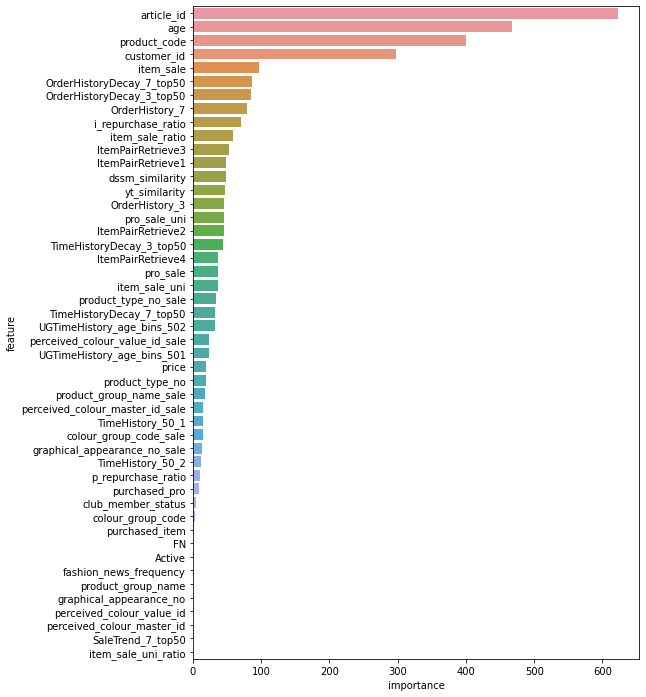

In [46]:
feat_importance = pd.DataFrame(
    {"feature": feats, "importance": ranker.feature_importance()}
).sort_values(by="importance", ascending=False)
plt.figure(figsize=(8, 12))
sns.barplot(y="feature", x="importance", data=feat_importance)

### Validate

In [47]:
val_candidates = valid.reset_index(drop=True)

In [48]:
probs = np.zeros(val_candidates.shape[0])
batch_size = 5_000_000
for batch in tqdm(range(0, val_candidates.shape[0], batch_size)):
    outputs = ranker.predict(val_candidates.loc[batch : batch + batch_size - 1, feats])
    probs[batch : batch + batch_size] = outputs

100%|██████████| 2/2 [00:04<00:00,  2.27s/it]


In [49]:
val_candidates["prob"] = probs

In [50]:
pred_lgb = val_candidates[['customer_id','article_id','prob']]
pred_lgb = pred_lgb.sort_values(by=["customer_id","prob"], ascending=False).reset_index(drop=True)
pred_lgb.rename(columns={'article_id':'prediction'}, inplace=True)

In [51]:
pred_lgb = pred_lgb.drop_duplicates(['customer_id', 'prediction'], keep='first')

In [52]:
pred_lgb = pred_lgb.groupby("customer_id")["prediction"].progress_apply(list).reset_index()

100%|██████████| 1371980/1371980 [03:40<00:00, 6211.86it/s]


In [53]:
label = labels[1]
label = pd.merge(label, pred_lgb, on="customer_id", how="left")

In [54]:
# with open('bring_to_top12.pkl', 'rb') as f:
#     item_focus = pickle.load(f)

In [55]:
map_at_k(label["article_id"], label["prediction"], k=12)

# 0.02820525160663368 1-week add normalization
# 0.028936597823123886 4-week 0.0274
# 0.029111989281461418 4-week drop full-negative customer
# 0.029165419468984943 3-week 0.0270

0.028297597743100006

### Test

In [56]:
test_candidates = candidates[0].reset_index(drop=True)

In [57]:
# As the threshold is set mannually when generating candidates for test set, we need to change the name of the columns
test_candidates.rename(columns = {
    'SaleTrend_7_top4':'SaleTrend_7_top50', 
    'TimeHistoryDecay_3_top31':'TimeHistoryDecay_3_top50',
    'TimeHistoryDecay_7_top24':'TimeHistoryDecay_7_top50',
    'TimeHistory_25_1':'TimeHistory_50_1', 
    'TimeHistory_30_2':'TimeHistory_50_2', 
    'UGSaleTrend_3_top2':'UGSaleTrend_7_top50', 
    'UGTimeHistory_age_bins_351':'UGTimeHistory_age_bins_501',
    'UGTimeHistory_age_bins_38.52':'UGTimeHistory_age_bins_502'
},inplace=True)

In [58]:
probs = np.zeros(test_candidates.shape[0])
batch_size = 5_000_000
for batch in tqdm(range(0, test_candidates.shape[0], batch_size)):
    outputs = ranker.predict(test_candidates.loc[batch : batch + batch_size - 1, feats])
    probs[batch : batch + batch_size] = outputs

100%|██████████| 20/20 [01:58<00:00,  5.95s/it]


In [59]:
test_candidates["prob"] = probs

In [60]:
pred_lgb = test_candidates[['customer_id','article_id','prob']]
pred_lgb = pred_lgb.sort_values(by=["customer_id","prob"], ascending=False).reset_index(drop=True)
pred_lgb.rename(columns={'article_id':'prediction'}, inplace=True)

In [61]:
idx2uid = pickle.load(open(data_dir/"index_id_map/user_index2id.pkl", "rb"))
idx2iid = pickle.load(open(data_dir/"index_id_map/item_index2id.pkl", "rb"))

In [62]:
pred_lgb['prediction'] = pred_lgb['prediction'].map(idx2iid).progress_apply(lambda x:'0'+str(x))
pred_lgb = pred_lgb.groupby('customer_id')['prediction'].progress_apply(list).reset_index()
pred_lgb['prediction'] = pred_lgb['prediction'].progress_apply(lambda x: ' '.join(x[:12]))

100%|██████████| 1371980/1371980 [00:02<00:00, 489983.60it/s]


In [63]:
uid2idx = pickle.load(open(data_dir/"index_id_map/user_id2index.pkl", "rb"))
submission = pd.read_csv(data_dir/"raw"/'sample_submission.csv')
submission['customer_id'] = submission['customer_id'].map(uid2idx)

In [64]:
del submission['prediction']
submission = submission.merge(pred_lgb, on='customer_id', how='left')
submission['customer_id'] = submission['customer_id'].map(idx2uid)

In [76]:
submission.to_csv('submission.csv.gz', index=False)

In [66]:
submission.head()

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0762846027 0568601043 0919273002 0918522001 07...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0762846027 0918522001 0918292001 0158340001 09...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0762846027 0805000001 0918522001 09...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0762846027 0918522001 0751471001 0751471043 09...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0896152001 0762846027 0896152002 0791587001 09...


### Submit

In [74]:
submit_msg = """
0.028297597743100006 6-week
---
OrderHistory(train, 3),
OrderHistory(train, 7),
OrderHistoryDecay(train, 3, n=50),
OrderHistoryDecay(train, 7, n=50),
ItemPair(OrderHistory(train, 3).retrieve(), name='1'),
ItemPair(OrderHistory(train, 7).retrieve(), name='2'),
ItemPair(OrderHistoryDecay(train, 3, n=50).retrieve(), name='3'),
ItemPair(OrderHistoryDecay(train, 7, n=50).retrieve(), name='4'),
UserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=50 if week!=0 else 15, name='1'),
UserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=50 if week!=0 else 20.5, name='2'),
UserGroupSaleTrend(data, customer_list, train, ['age_bins'], 7, n=50 if week!=0 else 2),
TimeHistory(customer_list, last_week, n=50 if week!=0 else 9, name='1'),
TimeHistory(customer_list, last_3days, n=50 if week!=0 else 16, name='2'),
TimeHistoryDecay(customer_list, train, 3, n=50 if week!=0 else 12),
TimeHistoryDecay(customer_list, train, 7, n=50 if week!=0 else 8),
SaleTrend(customer_list, train, 7, n=50 if week!=0 else 2)
---
min_pos_rate = 0.005
pivot
"""

In [75]:
submit_msg

"\n0.028297597743100006 6-week\n---\nOrderHistory(train, 3),\nOrderHistory(train, 7),\nOrderHistoryDecay(train, 3, n=50),\nOrderHistoryDecay(train, 7, n=50),\nItemPair(OrderHistory(train, 3).retrieve(), name='1'),\nItemPair(OrderHistory(train, 7).retrieve(), name='2'),\nItemPair(OrderHistoryDecay(train, 3, n=50).retrieve(), name='3'),\nItemPair(OrderHistoryDecay(train, 7, n=50).retrieve(), name='4'),\nUserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=50 if week!=0 else 15, name='1'),\nUserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=50 if week!=0 else 20.5, name='2'),\nUserGroupSaleTrend(data, customer_list, train, ['age_bins'], 7, n=50 if week!=0 else 2),\nTimeHistory(customer_list, last_week, n=50 if week!=0 else 9, name='1'),\nTimeHistory(customer_list, last_3days, n=50 if week!=0 else 16, name='2'),\nTimeHistoryDecay(customer_list, train, 3, n=50 if week!=0 else 12),\nTimeHistoryDecay(customer_list, train, 7, n=50 if week!=0 else 8),\nSaleTre

In [78]:
! kaggle competitions submit -c h-and-m-personalized-fashion-recommendations -f "submission.csv.gz" -m '\n0.029111989281461418 4-week drop full negative user\n---\nOrderHistory(train, 3),\nOrderHistory(train, 7),\nOrderHistoryDecay(train, 3, n=50),\nOrderHistoryDecay(train, 7, n=50),\nItemPair(OrderHistory(train, 3).retrieve(), name='1'),\nItemPair(OrderHistory(train, 7).retrieve(), name='2'),\nItemPair(OrderHistoryDecay(train, 3, n=50).retrieve(), name='3'),\nItemPair(OrderHistoryDecay(train, 7, n=50).retrieve(), name='4'),\nUserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=50 if week!=0 else 15, name='1'),\nUserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=50 if week!=0 else 20.5, name='2'),\nUserGroupSaleTrend(data, customer_list, train, ['age_bins'], 7, n=50 if week!=0 else 2),\nTimeHistory(customer_list, last_week, n=50 if week!=0 else 9, name='1'),\nTimeHistory(customer_list, last_3days, n=50 if week!=0 else 16, name='2'),\nTimeHistoryDecay(customer_list, train, 3, n=50 if week!=0 else 12),\nTimeHistoryDecay(customer_list, train, 7, n=50 if week!=0 else 8),\nSaleTrend(customer_list, train, 7, n=50 if week!=0 else 2)\n---\nmin_pos_rate = 0.006\npivot\n'


100%|######################################| 69.6M/69.6M [00:03<00:00, 23.5MB/s]
Successfully submitted to H&M Personalized Fashion Recommendations